# Introduction to Rigid Bodies

## Overview

### Questions

* What is a rigid body? 
* What properties do I need to input to simulate correct dynamics?

### Objectives

* Define a **rigid body** as a set of **constituent particles**.
* Describe the coordinate systems that apply to rigid bodies.
* Enumerate the properties of rigid bodies.
* Demonstrate computing the properties of a rigid dimer.

## Boilerplate code

In [1]:
import numpy
import matplotlib.pyplot

The `plot_spheres` function in the next (hidden) cell will render the rigid body using **matplotlib**.

<div class="alert alert-info">
    This is not intended as a full tutorial on <b>matplotlib</b> - see the <a href="https://matplotlib.org/">documentation</a> if you would like to learn more.
</div>

In [2]:
def sphere_coords(rad,pos):   
    # draw sphere
    u, v = numpy.mgrid[0:2*numpy.pi:20j, 0:numpy.pi:10j]
    x = rad * numpy.cos(u)*numpy.sin(v) + pos[0]
    y = rad * numpy.sin(u)*numpy.sin(v) + pos[1]
    z = rad * numpy.cos(v) + pos[2]
    return x,y,z

def plot_spheres(pos,ax,rad):
    for i in range(len(pos)):
        pos_tmp = pos[i,:]
        x,y,z = sphere_coords(rad,pos_tmp)
        ax.plot_wireframe(x,y,z,color='coral')

# What is a rigid body? 

A **rigid body** is an incompressible body composed of **constituent** particles. The sum of forces on the **constituent** particles leads to a net force and torque on the body.

# What coordinates are rigid bodies defined in?

A rigid body's constituent particles are defined in the **local** coordinates of the rigid body.

Every instance of a rigid body in a simulation is placed in the system **global** coordinates.  

**Local coordinates:** Coordinates in the frame of reference of the rigid body. This coordinate system is used to define the positions and orientations of the constituent particles with respect to the center of the body. 

**Global coordinates:** Coordinates in the frame of reference of the system.

# What physical quantities do I need to define a rigid body?

A rigid body is defined by:

* **Mass -** the total mass of the rigid body.
* **Moment of inertia tensor -** how mass is distributed throughout the rigid body as well as how the rigid body responds to torque.
* **Velocity -** velocity of the center of mass of the rigid body.
* **Angular velocity -** rotational velocity of the rigid body.
* **Position** in global coordinates, defined as a positional vector.
    * Example: position = [1.,1.,1.]
* **Orientation** A quaternion that rotates from local to global coordinates.
    * Example: orientation = [1.,0.,0.,0.]
* **Constituent Particle Positions** in local coordinates, defined as a positional vector from the center of the rigid body to the constituent particle.
* **Constituent Particle Orientation** A quaternion that rotates from the local coordinates of the constituent particles to the local coordinates of the rigid body.

# Rigid Dumbell Example

This section goes over how to define a rigid body made of two spheres of radius 1 'fused' together end to end.

Each sphere is a point particle of mass 1. 

The positions of the spheres in local coordinates of the rigid body are: 

\begin{equation}
    [[-1,0,0],\\
     [1,0,0]]
\end{equation}

A visualization of the spheres in local coordinates is shown below with vectors projected to their central positions. 

<function matplotlib.pyplot.show(close=None, block=None)>

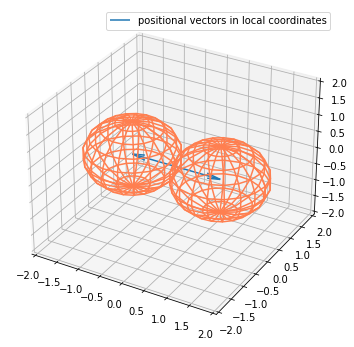

In [3]:
# Visualization for the spheres in matplotlib as a wiremesh.
sphere_pos = numpy.array([[1,0,0],[-1,0,0]])
vectors = numpy.array([[0,0,0,1.,0,0],[0,0,0,-1.,0,0]])

X, Y, Z, U, V, W = zip(*vectors)

radius = 1.

matplotlib.pyplot.rcParams['figure.figsize'] = [20, 20]
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(133, projection='3d')

plot_spheres(sphere_pos,ax,radius)
ax.quiver(X,Y,Z,U,V,W,label='positional vectors in local coordinates')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)
matplotlib.pyplot.legend()
matplotlib.pyplot.show

# Getting the mass and moment of inertia

Because each sphere is assumed to be a point particle with mass m rotating about point (0,0,0), we can get the moment of inertia of each point particle by integrating over volume, with the general process outlined here: https://farside.ph.utexas.edu/teaching/336k/Newtonhtml/node64.html. 

Off diagonal terms are zero for these point particles, and the moment of inertia tensor is the same for each particle written as:

\begin{bmatrix}
0&0&0\\
0& 1& 0\\
0&0&1
\end{bmatrix}

The sum of the moment of inertia of the rigid body is the sum of the moment of inertia of the constituents

\begin{equation}
    I_{tot} = \sum I_{constituents}
\end{equation}

The moment of inertia tensor of the rigid body is therefore:

\begin{bmatrix}
0&0&0\\
0& 2& 0\\
0&0&2
\end{bmatrix}

HOOMD only supports rigid bodies with diagonalized moments of inertia ($[I_{xx},I_{yy},I_{zz}]$).

In [4]:
I = [0,2,2]